In [1]:
import skimage
import matplotlib.pyplot as plt
import jseg
from jseg.data import overlapping_circles
from jseg.evaluation import segmentation_type
from skimage.metrics import variation_of_information, adapted_rand_error, contingency_table
import numpy as np
import jseg.evaluation as jeval
from collections import defaultdict

## Overlapping Circles

In [3]:
# Which segmentatons types are available
jeval.SEGMENTATION_TYPES

['extra-segmentation',
 'missed-segmentation',
 'correct-segmentation',
 'over-segmentation',
 'under-segmentation',
 'divergent-segmentation']

RATES: correct 0.5, over 0.0, under 0.0, miss 0.5, divergent 0.0
Over segmentation:  0.0  Under segmentation:  0.0  Adapted random Error:  0.0  ar-prec:  1.0  ar rec:  1.0


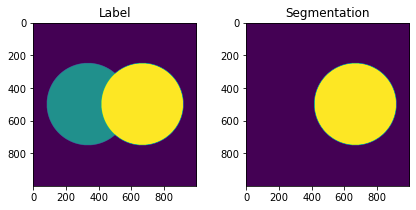

In [8]:
# Plot a segmentation type and the corresponding values
## Setup figure
shape = (1000, 1000)
fig,axs = plt.subplots(1,2)
fig.set_size_inches(7,3)

## Get iamges
label, segmentation = overlapping_circles(segmentation_type= 'missed-segmentation',
                                            background_label = 1,
                                            shape = shape,
                                            label_shift = False)


## Plot images
axs[0].imshow(label)
axs[0].set_title("Label")
axs[1].imshow(segmentation)
axs[1].set_title("Segmentation")

# Calculate measures of segmentation
num_gt = len(np.unique(label))-1
ct = contingency_table(label, segmentation, ignore_labels=(0,), normalize=False)
ct1 = contingency_table(label, segmentation, ignore_labels=(1,), normalize=False)
ov, un = variation_of_information(label, segmentation, table = ct1)
are, prec, rec = adapted_rand_error(label, segmentation,table = ct1)
cor ,ovr, unr, mir, dir =  segmentation_type(ct,num_gt, background_label=1)
print(f"RATES: correct {cor}, over {ovr}, under {unr}, miss {mir}, divergent {dir}")
print("Over segmentation: ", ov, " Under segmentation: ", un, " Adapted random Error: ", are, " ar-prec: ", prec, " ar rec: ", rec)

